In [ ]:
pip install 'numpy<2.3'

In [ ]:
pip install shap

In [ ]:
pip install seaborn

In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ca1678e46540aa8ac350b09ef7a96fc0c0ae7fc569e7a3e3ddf0e3bb43a8e9b7
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


Order of Steps:

- Load & Clean Data
- Exploratory Data Analysis (EDA)
    - Class distribution
    - Time & amount histograms
    - Correlation matrix
- Preprocessing
    - Feature scaling
    - Train-test split
- Model Training (KNN)
- Evaluation & Visualization
- Interpretability (SHAP, LIME)

Load Data

In [ ]:
import pandas as pd

df = pd.read_csv("creditcard.csv")
df = df.drop_duplicates()


Exploratory Data Analysis

1.Class Distribution

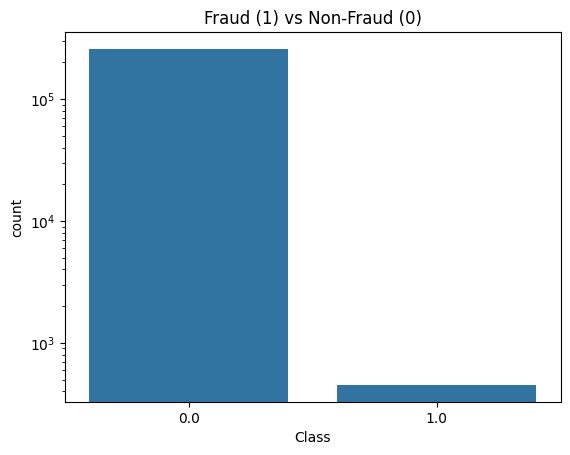

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Class', data=df)
plt.yscale('log')
plt.title("Fraud (1) vs Non-Fraud (0)")
plt.show()


2. Time & amount histograms

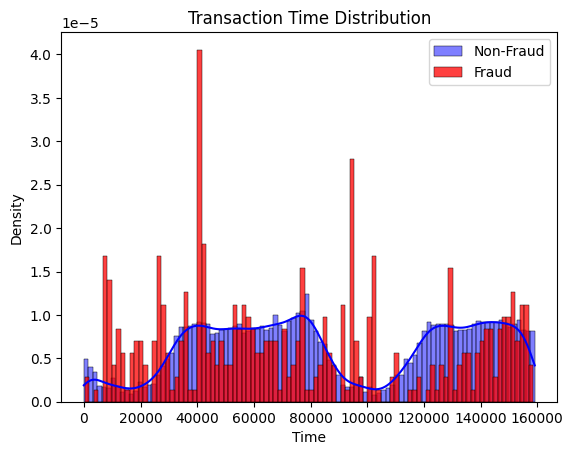

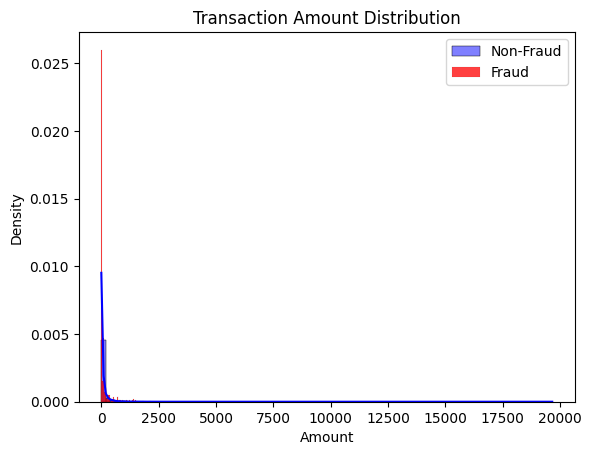

In [ ]:
# Time distribution
sns.histplot(df[df['Class'] == 0]['Time'], bins=100, color='blue', label='Non-Fraud', stat='density', kde=True)
sns.histplot(df[df['Class'] == 1]['Time'], bins=100, color='red', label='Fraud', stat='density', kde=False)
plt.title("Transaction Time Distribution")
plt.legend()
plt.show()

# Amount distribution
sns.histplot(df[df['Class'] == 0]['Amount'], bins=100, color='blue', label='Non-Fraud', stat='density', kde=True)
sns.histplot(df[df['Class'] == 1]['Amount'], bins=100, color='red', label='Fraud', stat='density', kde=False)
plt.title("Transaction Amount Distribution")
plt.legend()
plt.show()


Correlation Matrix (Heatmap)

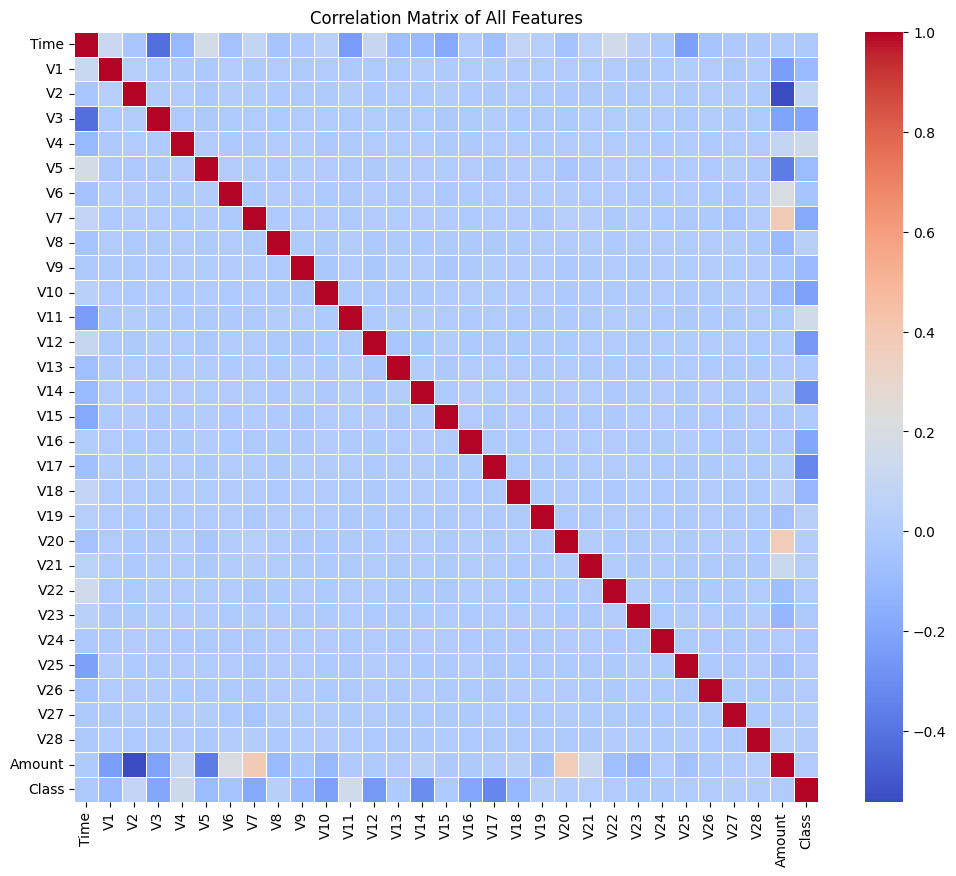

In [ ]:
# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap of top correlated features with 'Class'
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of All Features")
plt.show()


Correlation with Target Class Only

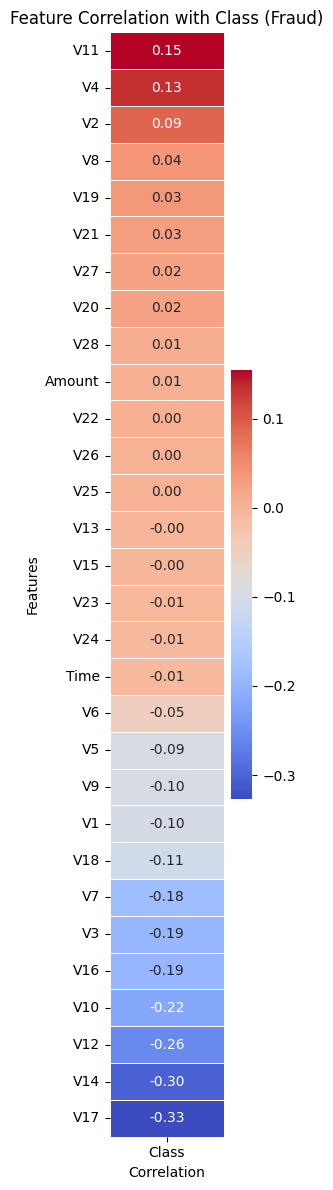

In [ ]:
# Correlation of features with 'Class'
corr_with_class = corr_matrix["Class"].drop("Class").sort_values(ascending=False)

# Plot vertical heatmap
plt.figure(figsize=(3, 12))
sns.heatmap(corr_with_class.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Feature Correlation with Class (Fraud)")
plt.xlabel("Correlation")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


PCA - for 2D visualization of the data.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = [col for col in df.columns if col not in ['Class', 'Time']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

labels = df['Class']
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[labels == 0, 0], X_pca[labels == 0, 1], alpha=0.5, label='Non-Fraud', c='blue', s=10)
plt.scatter(X_pca[labels == 1, 0], X_pca[labels == 1, 1], alpha=0.5, label='Fraud', c='red', s=15)
plt.title("PCA - Fraud vs Non-Fraud")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Preprocessing

1. Feature scaling
2. Train-test split

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Class", "Time"])
y = df["Class"]

scaler = StandardScaler()
X["Amount"] = scaler.fit_transform(X[["Amount"]])

#2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


KNN - Model Trainng

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


Evaluation & Visualization

1. Metrics
 - AUPRC
 - ROC-AUC
 - F1 Score
 - Precision
 - Recall
 - Classification Report


In [ ]:
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score, auc, f1_score, precision_score, recall_score

y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
roc_auc = roc_auc_score(y_test, y_prob)

print("AUPRC:", pr_auc)
print("ROC-AUC:", roc_auc)
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


AUPRC: 0.8485513982930736
ROC-AUC: 0.8998954819397438
F1 Score: 0.8242424242424242
Precision: 0.9714285714285714
Recall: 0.7157894736842105

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.97      0.72      0.82        95

    accuracy                           1.00     56746
   macro avg       0.99      0.86      0.91     56746
weighted avg       1.00      1.00      1.00     56746



Evalution Using Confusion Matrix

Structure of a Confusion Matrix
For a binary classification problem (like fraud detection), the matrix looks like this:

Predicted: No Fraud (0)	Predicted: Fraud (1)
Actual: No Fraud (0)	True Negative (TN)	False Positive (FP)
Actual: Fraud (1)	False Negative (FN)	True Positive (TP)
🔍 What Each Term Means
True Positive (TP): Model correctly predicted fraud.
True Negative (TN): Model correctly predicted non-fraud.
False Positive (FP): Model incorrectly predicted fraud (false alarm).
False Negative (FN): Model missed a fraud case.
🧠 Why It's Useful
From the confusion matrix, you can calculate key metrics:

Accuracy = (TP + TN) / Total
Precision = TP / (TP + FP)
Recall (Sensitivity) = TP / (TP + FN)
F1 Score = Harmonic mean of precision and recall

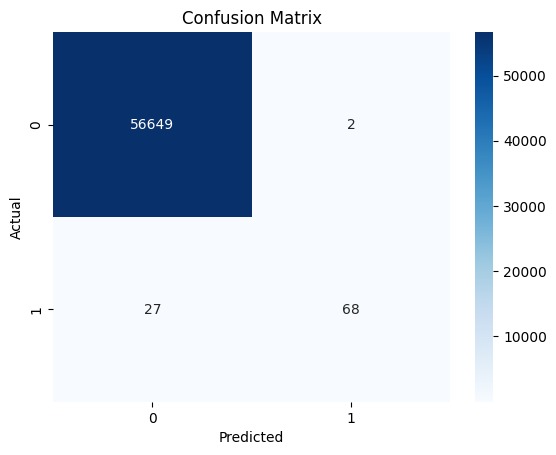

In [ ]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


ROC Curve (Receiver Operating Characteristic)
The ROC curve plots:

X-axis: False Positive Rate (FPR) = FP / (FP + TN)
Y-axis: True Positive Rate (TPR) = Recall = TP / (TP + FN)
It shows how well the model distinguishes between classes at various thresholds.

Key Metric: AUC-ROC
AUC (Area Under Curve): Measures the overall ability of the model to distinguish fraud from non-fraud.
AUC = 1.0: Perfect classifier
AUC = 0.5: Random guessing



----

Precision-Recall Curve (Recall Curve)
This curve is especially useful for imbalanced datasets like fraud detection.

X-axis: Recall (TP / TP + FN)
Y-axis: Precision (TP / TP + FP)
It shows the trade-off between catching more frauds (recall) and avoiding false alarms (precision).


Key Metric: AUPRC
AUPRC (Area Under Precision-Recall Curve): Higher is better.
More informative than ROC when the positive class (fraud) is rare.

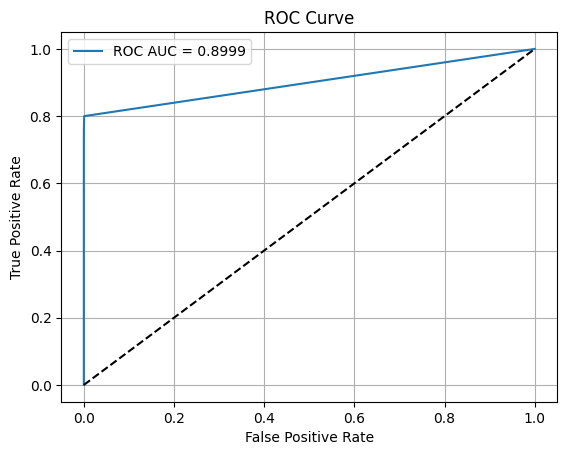

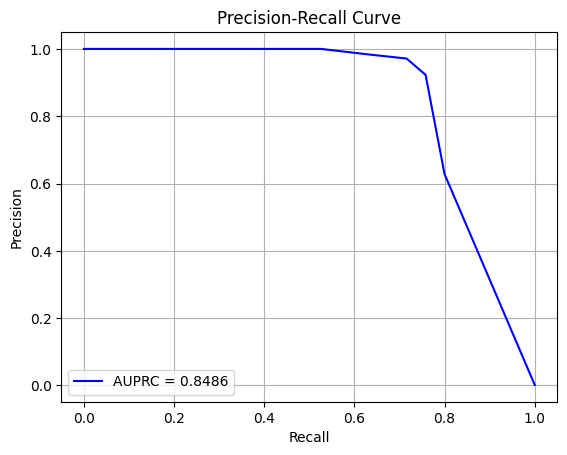

In [ ]:
from sklearn.metrics import roc_curve

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve
plt.plot(recall, precision, label=f"AUPRC = {pr_auc:.4f}", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


SHAP Values

What Are SHAP Values?
SHAP (SHapley Additive exPlanations) values are a powerful tool for interpreting machine learning models. They explain how much each feature contributed to a particular prediction.

🧠 Intuition Behind SHAP
SHAP is based on game theory — imagine each feature as a "player" in a game, and the model's prediction as the "payout." SHAP calculates how much each feature contributes to the final prediction by considering all possible combinations of features.

📊 What SHAP Tells You
Positive SHAP value: Feature pushes the prediction toward fraud.
Negative SHAP value: Feature pushes the prediction toward non-fraud.
Magnitude: Indicates how strongly the feature influenced the prediction.
📈 Common SHAP Visualizations
Summary Plot: Shows global feature importance and direction of impact.
Force Plot: Visualizes how features push an individual prediction.
Dependence Plot: Shows how a feature’s value affects its SHAP value

100%|██████████| 10/10 [03:48<00:00, 22.84s/it]


Shape of X_test.iloc[:10]: (10, 29)
shap_values is a numpy array. Shape: (10, 29, 2)
Shape of shap_values_to_plot (after correct slicing): (10, 29)


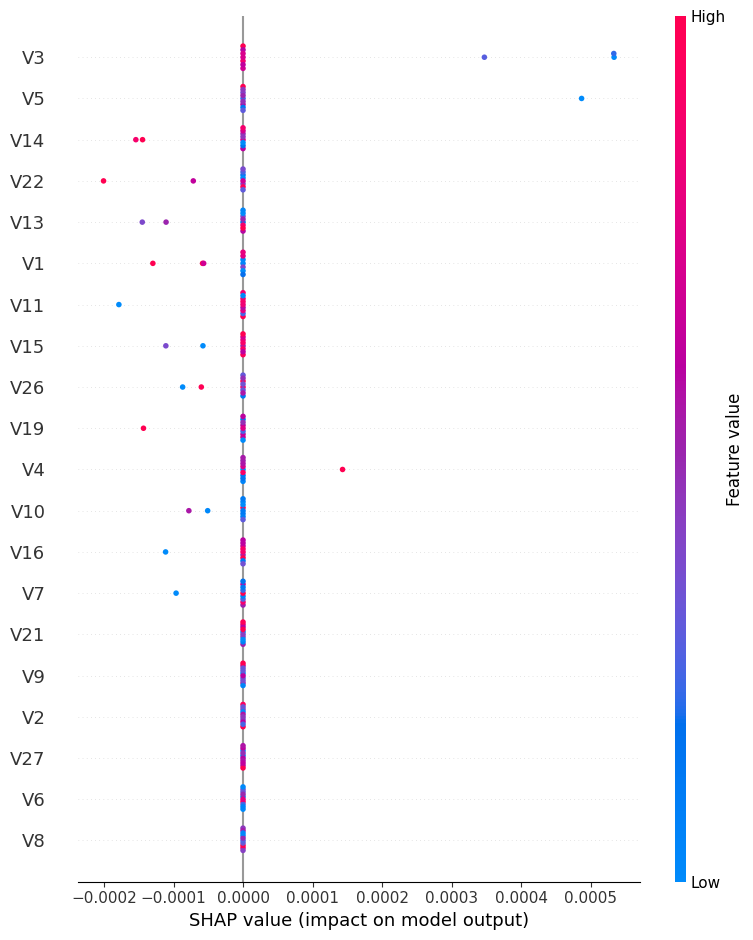

In [ ]:
import shap
import matplotlib.pyplot as plt # Ensure plt is imported


# Use a small background sample for efficiency
background = shap.sample(X_train, 100)

# Create KernelExplainer for KNN
# Pass the probability prediction function
explainer = shap.KernelExplainer(knn.predict_proba, background)

# Explain a few test samples
# shap_values will be a list of two arrays for binary classification
# shap_values[0] for class 0, shap_values[1] for class 1
shap_values = explainer.shap_values(X_test.iloc[:10])

print(f"Shape of X_test.iloc[:10]: {X_test.iloc[:10].shape}")
if isinstance(shap_values, list):
    print(f"shap_values is a list. Length: {len(shap_values)}")
    print(f"Shape of shap_values[0]: {shap_values[0].shape}")
    print(f"Shape of shap_values[1]: {shap_values[1].shape}")
else:
    print(f"shap_values is a numpy array. Shape: {shap_values.shape}")

shap_values_to_plot = shap_values[:, :, 1]

print(f"Shape of shap_values_to_plot (after correct slicing): {shap_values_to_plot.shape}")

# Summary plot
shap.summary_plot(shap_values_to_plot, X_test.iloc[:10])

plt.show()

What is LIME?
LIME (Local Interpretable Model-agnostic Explanations) is a technique used to explain the predictions of any machine learning model by approximating it locally with an interpretable model (like linear regression).

🔍 How LIME Works
Pick a prediction you want to explain (e.g., a fraud prediction).
Perturb the input slightly (create similar samples).
Observe how the model's prediction changes.
Fit a simple model (like linear regression) to approximate the complex model locally.
Show which features contributed most to that specific prediction.

In [ ]:
import lime
import lime.lime_tabular
import numpy as np # Ensure numpy is imported for operations like np.argmax

# 1. Define the prediction function for LIME
predict_fn_lime = knn.predict_proba

# 2. Get feature names
feature_names = X_train.columns.tolist()

# 3. Get class names
class_names = ['Non-Fraud', 'Fraud'] # Assuming 0 is Non-Fraud and 1 is Fraud

# 4. Create the LIME Explainer
# training_data: Essential for LIME to understand the data distribution for perturbation.
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    kernel_width=0.75
)

# 5. Choose an instance from X_test to explain
# For example, the first instance in your test set
instance_to_explain_idx = 0
instance_to_explain = X_test.iloc[instance_to_explain_idx]

# Print actual and predicted class for the chosen instance
print(f"\n--- LIME Explanation for Instance {instance_to_explain_idx} ---")
print(f"Actual Class: {y_test.iloc[instance_to_explain_idx]} ({class_names[y_test.iloc[instance_to_explain_idx]]})")

# Reshape single instance for predict_fn_lime
predicted_proba = predict_fn_lime(instance_to_explain.to_frame().T)[0]
print(f"Predicted Probabilities: Class 0: {predicted_proba[0]:.4f}, Class 1: {predicted_proba[1]:.4f}")
print(f"Predicted Class: {np.argmax(predicted_proba)} ({class_names[np.argmax(predicted_proba)]})")

# 6. Explain the instance
# num_features: How many top features to include in the explanation.
# num_samples: How many perturbed samples to generate around the instance for the local model.
explanation = explainer_lime.explain_instance(
    data_row=instance_to_explain.values, # LIME expects a numpy array for data_row
    predict_fn=predict_fn_lime,
    num_features=10, # Display top 10 contributing features
    num_samples=1000 # Number of permutations LIME will create for the local model
)

# 7. Print the explanation
print("\nFeature importance (LIME) for this instance:")
print(explanation.as_list())

# To visualize in a Jupyter Notebook (if applicable):
# explanation.show_in_notebook(show_all=False)

# If you want to get a Matplotlib figure for saving or non-notebook display:
# fig = explanation.as_pyplot_figure()
# plt.show(fig) # You might need to adjust based on your matplotlib backend


--- LIME Explanation for Instance 0 ---
Actual Class: 0 (Non-Fraud)
Predicted Probabilities: Class 0: 1.0000, Class 1: 0.0000
Predicted Class: 0 (Non-Fraud)

Feature importance (LIME) for this instance:
[('0.02 < V1 <= 1.32', 0.0), ('-0.60 < V2 <= 0.06', 0.0), ('0.18 < V3 <= 1.03', 0.0), ('-0.02 < V4 <= 0.74', 0.0), ('-0.05 < V5 <= 0.62', 0.0), ('-0.28 < V6 <= 0.40', 0.0), ('-0.55 < V7 <= 0.04', 0.0), ('0.02 < V8 <= 0.33', 0.0), ('V9 > 0.59', 0.0), ('-0.54 < V10 <= -0.09', 0.0)]


/Users/shivaninagpal/Documents/Amit/Project/python-learn/ML2/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
